### Power calculation

In [13]:
from scipy.stats import norm
import numpy as np

def randomized_study_power_one_tail(n1, n2, mu1, sigma1, mu2, sigma2, alpha=0.05):
    """
    Calculate the power for a one-tailed t-test in a randomized study.

    Parameters:
    - n1, n2: Sample sizes for treated and control groups.
    - mu1, sigma1: Mean and standard deviation for the treated group.
    - mu2, sigma2: Mean and standard deviation for the control group.
    - alpha: Significance level (default 0.05).

    Returns:
    - power: Statistical power of the test.
    """
    pooled_se = np.sqrt((sigma1**2 / n1) + (sigma2**2 / n2))
    effect_size = (mu1 - mu2) / pooled_se
    critical_value = norm.ppf(1 - alpha)
    non_centrality = effect_size
    power = 1 - norm.cdf(critical_value - non_centrality)
    return power

# Example inputs
n1 = 100  # Sample size for treated group
n2 = 90  # Sample size for control group
mu1 = 5.0  # Mean for treated group
sigma1 = 1.2  # Standard deviation for treated group
mu2 = 4.5  # Mean for control group
sigma2 = 1.5  # Standard deviation for control group
alpha = 0.05  # Significance level
power = randomized_study_power_one_tail(n1, n2, mu1, sigma1, mu2, sigma2, alpha)
print(f"Statistical Power: {power:.4f}")

Statistical Power: 0.8090


### Power curves

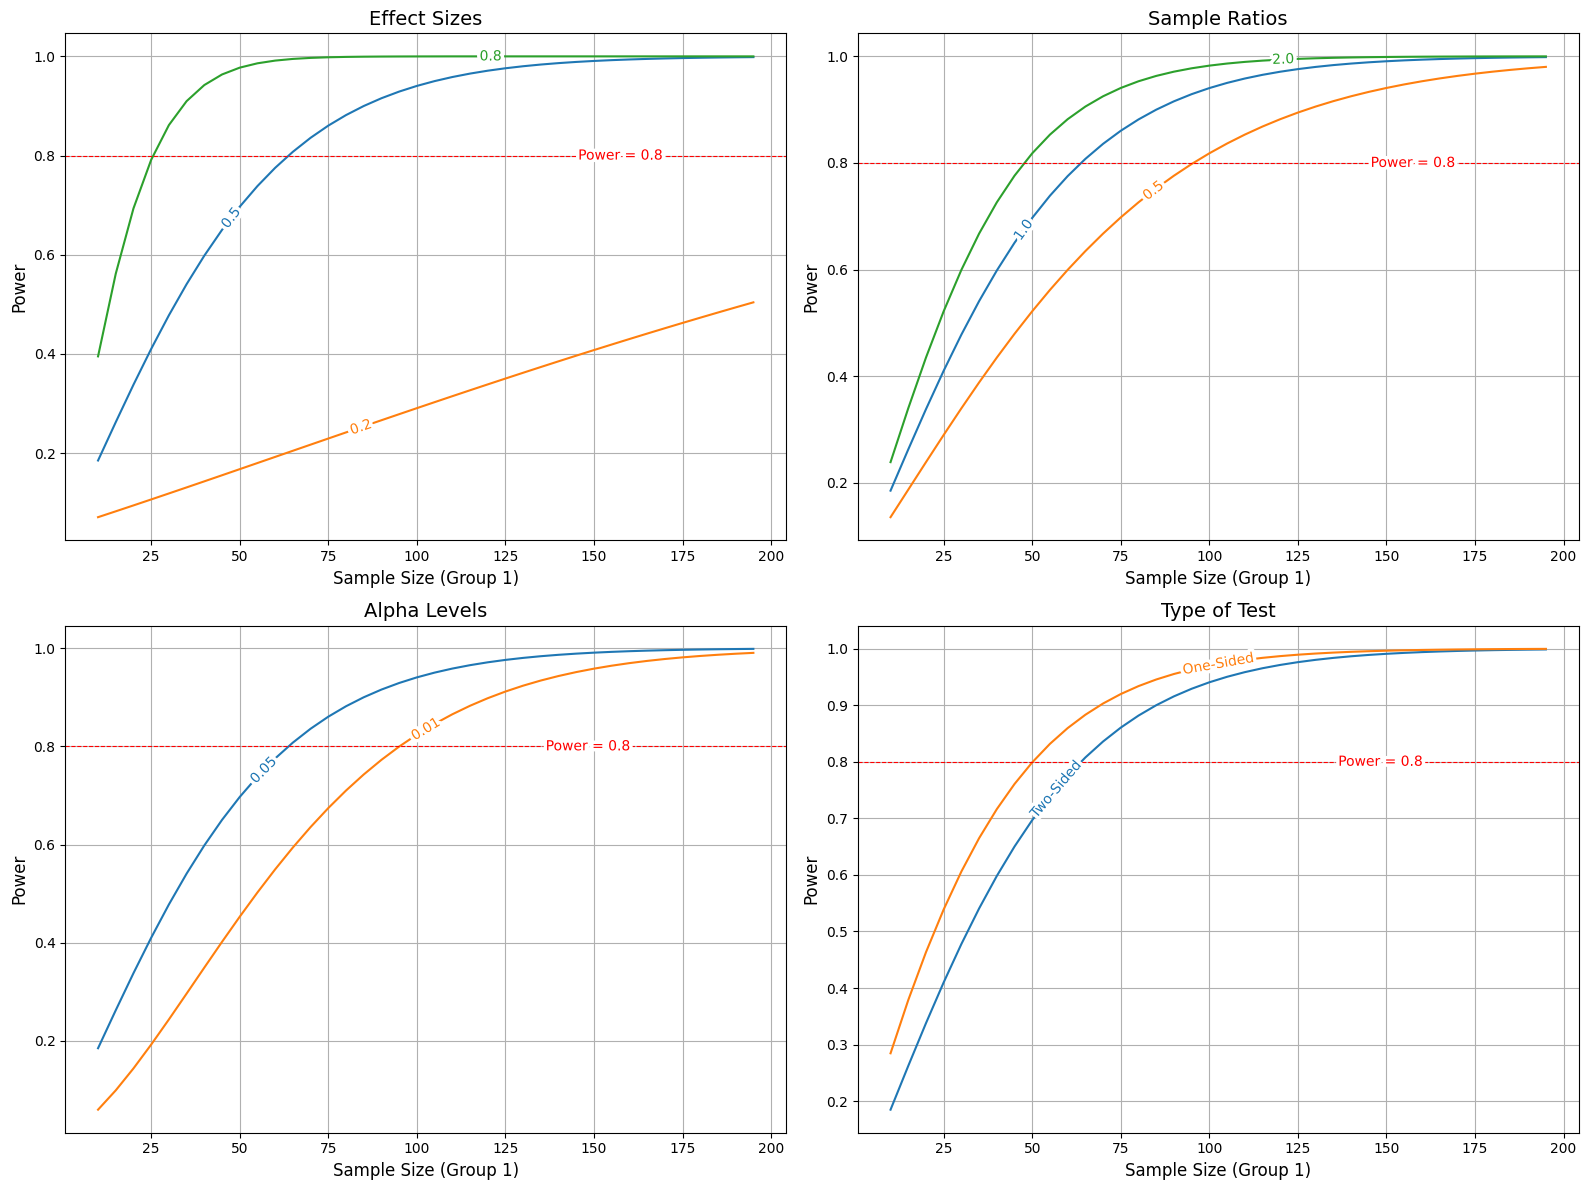

In [23]:
# Import libraries
from statsmodels.stats.power import TTestIndPower
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines

# Define the base case parameters
base_effect_size = 0.5  # Medium effect size (Cohen's d)
base_alpha = 0.05       # Significance level
base_alternative = 'two-sided'  # Two-sided test
base_ratio = 1.0        # Equal sample sizes
sample_sizes = np.arange(10, 200, 5)  # Sample sizes for Group 1

# Initialize the power analysis object
analysis = TTestIndPower()

# Define variations grouped into categories for separate graphs
deviation_groups = {
    "Effect Sizes": [
        {"label": "0.5", "effect_size": 0.5, "alpha": base_alpha, "alternative": base_alternative, "ratio": base_ratio},
        {"label": "0.2", "effect_size": 0.2, "alpha": base_alpha, "alternative": base_alternative, "ratio": base_ratio},
        {"label": "0.8", "effect_size": 0.8, "alpha": base_alpha, "alternative": base_alternative, "ratio": base_ratio},
    ],
    "Sample Ratios": [
        {"label": "1.0", "effect_size": base_effect_size, "alpha": base_alpha, "alternative": base_alternative, "ratio": 1.0},
        {"label": "0.5", "effect_size": base_effect_size, "alpha": base_alpha, "alternative": base_alternative, "ratio": 0.5},
        {"label": "2.0", "effect_size": base_effect_size, "alpha": base_alpha, "alternative": base_alternative, "ratio": 2.0},
    ],
    "Alpha Levels": [
        {"label": "0.05", "effect_size": base_effect_size, "alpha": 0.05, "alternative": base_alternative, "ratio": base_ratio},
        {"label": "0.01", "effect_size": base_effect_size, "alpha": 0.01, "alternative": base_alternative, "ratio": base_ratio},
    ],
    "Type of Test": [
        {"label": "Two-Sided", "effect_size": base_effect_size, "alpha": base_alpha, "alternative": "two-sided", "ratio": base_ratio},
        {"label": "One-Sided", "effect_size": base_effect_size, "alpha": base_alpha, "alternative": "larger", "ratio": base_ratio},
    ]
}

# Plot each group of deviations in separate graphs with inline labels
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, (group_title, variations) in zip(axes, deviation_groups.items()):
    for variation in variations:
        # Compute power curve
        power_curve = [
            analysis.power(effect_size=variation["effect_size"],
                           nobs1=n,
                           alpha=variation["alpha"],
                           ratio=variation["ratio"],
                           alternative=variation["alternative"])
            for n in sample_sizes
        ]
        # Plot the curve
        ax.plot(sample_sizes, power_curve, label=variation["label"])
    
    # Add a horizontal line at Power = 0.8
    ax.axhline(y=0.8, color='red', linestyle='--', linewidth=0.8, label='Power = 0.8')
    
    # Customize the subplot
    ax.set_title(group_title, fontsize=14)
    ax.set_xlabel("Sample Size (Group 1)", fontsize=12)
    ax.set_ylabel("Power", fontsize=12)
    ax.grid(True)
    
    # Add inline labels for each line
    labelLines(ax.get_lines(), align=True, fontsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

### Efficient Experiments

(68, 2)


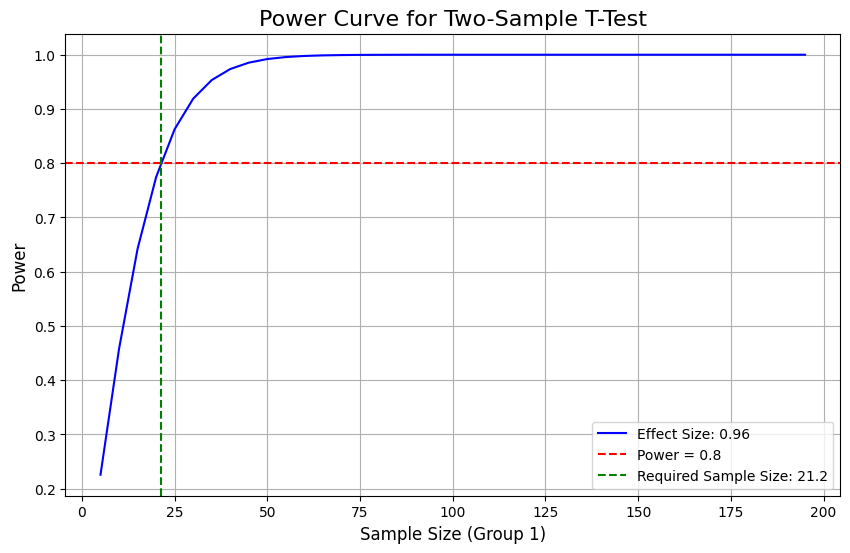

T-Test Results: {'River 1': 'Aripo', 'River 2': 'Guanapo', 'T-Statistic': 3.643852571762074, 'P-Value': 0.0006697632019354975}
Effect Size (Cohen's d): 0.957
Required Sample Size for 80% Power: 21.2


In [30]:
import pandas as pd
data = pd.read_csv('data/CS1-twosample.csv')
print(data.shape)

# Import libraries
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower
import numpy as np
import matplotlib.pyplot as plt

# (1) Perform the t-test
# Group the data by river
grouped_data = data.groupby('river')
river_groups = {river: group['length'].values for river, group in grouped_data}

# Extract lengths for each river
(river1, data1), (river2, data2) = river_groups.items()

# Perform Welch's t-test
t_stat, p_value = ttest_ind(data1, data2, equal_var=False)
t_test_results = {
    'River 1': river1,
    'River 2': river2,
    'T-Statistic': t_stat,
    'P-Value': p_value
}

# (2) Compute the power curve and find required sample size
# Initialize the power analysis object
analysis = TTestIndPower()

# Calculate effect size (Cohen's d)
mean1, std1, n1 = data1.mean(), data1.std(), len(data1)
mean2, std2, n2 = data2.mean(), data2.std(), len(data2)
pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
effect_size = (mean1 - mean2) / pooled_std

# Find required sample size for 80% power
required_sample_size = analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05, ratio=n2 / n1, alternative='two-sided')

# Generate the power curve
sample_sizes = np.arange(5, 200, 5)
power_curve = [
    analysis.power(effect_size=effect_size, nobs1=n, alpha=0.05, ratio=n2 / n1, alternative='two-sided')
    for n in sample_sizes
]

# Plot the power curve
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, power_curve, label=f'Effect Size: {effect_size:.2f}', color='blue')
plt.axhline(y=0.8, color='red', linestyle='--', label='Power = 0.8')
plt.axvline(x=required_sample_size, color='green', linestyle='--', label=f'Required Sample Size: {required_sample_size:.1f}')
plt.title('Power Curve for Two-Sample T-Test', fontsize=16)
plt.xlabel('Sample Size (Group 1)', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

# Output results
print("T-Test Results:", t_test_results)
print(f"Effect Size (Cohen's d): {effect_size:.3f}")
print(f"Required Sample Size for 80% Power: {required_sample_size:.1f}")


In [31]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Load lobster data
lobsters = pd.read_csv("data/CS2-lobsters.csv")

# Fit a linear model
model = smf.ols(formula="weight ~ C(diet)", data=lobsters).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model)
print(anova_results)

# Compute R-squared and use for eta-squared
R2 = model.rsquared

# Compute sample size needed
sample_size_anova = pg.power_anova(eta_squared=R2, k=3, power=0.80, alpha=0.05)
print(f"Sample size per group for ANOVA: {sample_size_anova}")


FileNotFoundError: [Errno 2] No such file or directory: 'data/CS2-lobsters.csv'

### Stratification and Clustering

In [8]:
from pypowerup import effect_size, power, sample_size

# Effect size calculation
mdes = effect_size(
    design='ira',  # Simple Individual Random Assignment (IRA)
    n=787,         # Total sample size
    power=0.8,     # Desired statistical power
    alpha=0.05,    # Significance level (Type I error)
    two_tailed=True,  # Two-tailed test
    p=0.5,         # Proportion of treatment group
    r21=0,         # Proportion of variance explained by covariates at Level 1
    g=0            # Number of covariates at the highest level
)
print(f"Minimum Detectable Effect Size (MDES): {mdes}")

# Sample size calculation
mrss = sample_size(
    design='ira',  # Simple Individual Random Assignment (IRA)
    es=0.2,        # Desired effect size
    power=0.8,     # Desired statistical power
    alpha=0.05,    # Significance level (Type I error)
    two_tailed=True,  # Two-tailed test
    p=0.5,         # Proportion of treatment group
    r21=0,         # Proportion of variance explained by covariates at Level 1
    g=0            # Number of covariates at the highest level
)
print(f"Minimum Required Sample Size (MRSS): {mrss}")

# Power calculation
stat_power = power(
    design='ira',  # Simple Individual Random Assignment (IRA)
    es=0.2,        # Effect size
    n=787,         # Total sample size
    alpha=0.05,    # Significance level (Type I error)
    two_tailed=True,  # Two-tailed test
    p=0.5,         # Proportion of treatment group
    r21=0,         # Proportion of variance explained by covariates at Level 1
    g=0            # Number of covariates at the highest level
)
print(f"Statistical Power: {stat_power}")


Minimum Detectable Effect Size (MDES): 0.19997988869985736
Minimum Required Sample Size (MRSS): 787
Statistical Power: 0.8000799952735076
